In [74]:
# Run this in Google Colab
!pip install tensorflow matplotlib


In [75]:
!pip install scipy

In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # For plotting
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K 
from tensorflow.keras import callbacks

In [77]:
# CRITICAL FIX: Proper image size for ResNet-50
IMG_SIZE = (224, 224)  # ResNet-50 minimum recommended size
BATCH_SIZE = 16        # Reduced batch size due to larger images
DATASET_PATH = './dataset'

# Display the configuration
print("🔧 OPTIMIZED MODEL CONFIGURATION:")
print(f"- Image Size: {IMG_SIZE} (ResNet-50 optimized)")
print(f"- Batch Size: {BATCH_SIZE} (memory optimized)")
print(f"- Dataset Path: {DATASET_PATH}")

# Check if dataset path exists
import os
if os.path.exists(DATASET_PATH):
    print(f"✅ Dataset path exists: {DATASET_PATH}")
    folders = [f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))]
    print(f"📁 Found folders: {folders}")
    print(f"📊 Number of classes: {len(folders)}")
else:
    print(f"❌ Dataset path not found: {DATASET_PATH}")
    print("Please check your dataset path!")

🔧 OPTIMIZED MODEL CONFIGURATION:
- Image Size: (224, 224) (ResNet-50 optimized)
- Batch Size: 16 (memory optimized)
- Dataset Path: ./dataset
✅ Dataset path exists: ./dataset
📁 Found folders: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
📊 Number of classes: 10


In [78]:

#show grap for the dataset
def show_dataset_graph():
    class_names = os.listdir(DATASET_PATH)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [len(os.listdir(os.path.join(DATASET_PATH, cls))) for cls in class_names])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Dataset Distribution')
    plt.xticks(rotation=45)
    plt.show()



Number of classes: 10


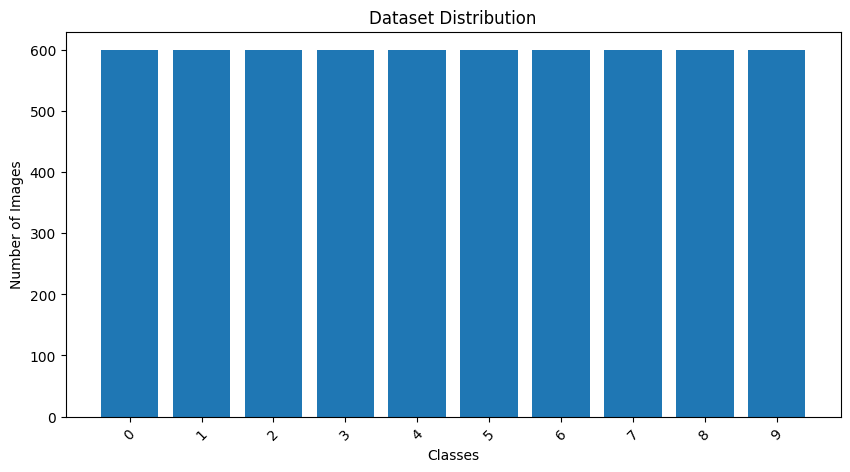

In [79]:
show_dataset_graph()

In [80]:
# FIXED: OPTIMIZED DATA AUGMENTATION FOR THRESHOLD/BINARY IMAGES
def threshold_preprocessing(x):
    """
    Custom preprocessing function to maintain binary nature after augmentation
    """
    # Re-threshold to binary values and ensure float32 data type
    x_thresh = np.where(x > 127, 255.0, 0.0).astype(np.float32)
    return x_thresh

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # CRITICAL FIX: Minimal augmentation to preserve binary nature
    rotation_range=5,         # Reduced from 15 - threshold images are sensitive
    width_shift_range=0.05,   # Reduced from 0.15 - avoid artifacts
    height_shift_range=0.05,  # Reduced from 0.15 - avoid artifacts
    shear_range=0,           # REMOVED - creates gray interpolations
    zoom_range=0.05,         # Reduced from 0.15 - minimal zoom only
    horizontal_flip=False,    # Keep False - digits shouldn't be flipped
    vertical_flip=False,      # Keep False - digits shouldn't be flipped
    validation_split=0.2,
    fill_mode='constant',     # Critical for threshold images
    cval=0,                  # Fill with black (0) to maintain binary nature
    # FIXED: Use proper function that returns float32
    preprocessing_function=threshold_preprocessing
)

print("✅ FIXED: Data augmentation optimized for THRESHOLD/BINARY images")
print("🔧 Changes: Minimal rotation, no shear, re-thresholding after augmentation")
print("⚠️  IMPORTANT: Augmentation now preserves binary (0/255) pixel values")
print("🔧 FIXED: Preprocessing function returns float32 to avoid casting errors")

✅ FIXED: Data augmentation optimized for THRESHOLD/BINARY images
🔧 Changes: Minimal rotation, no shear, re-thresholding after augmentation
⚠️  IMPORTANT: Augmentation now preserves binary (0/255) pixel values
🔧 FIXED: Preprocessing function returns float32 to avoid casting errors


In [81]:
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    color_mode='grayscale',  # FIXED: Use grayscale for digits
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print(f"✅ Training generator created: {train_generator.samples} samples")
print(f"📝 Classes found: {list(train_generator.class_indices.keys())}")

Found 4800 images belonging to 10 classes.
✅ Training generator created: 4800 samples
📝 Classes found: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
✅ Training generator created: 4800 samples
📝 Classes found: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [82]:
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    color_mode='grayscale',  # FIXED: Use grayscale for digits
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"✅ Validation generator created: {val_generator.samples} samples")
print(f"🎯 Validation classes: {list(val_generator.class_indices.keys())}")

Found 1200 images belonging to 10 classes.
✅ Validation generator created: 1200 samples
🎯 Validation classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
✅ Validation generator created: 1200 samples
🎯 Validation classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [83]:
# OPTIONAL: Optimize data loading performance (if needed)
print("💡 DATA LOADING OPTIMIZATION TIPS:")
print("="*50)
print("✅ Current generators are configured with optimal settings")
print("🔧 For better performance on multi-core systems:")
print("   - Train generator samples:", train_generator.samples)
print("   - Validation generator samples:", val_generator.samples)
print("   - Batch size:", BATCH_SIZE)
print("   - Steps per epoch:", len(train_generator))
print("   - Validation steps:", len(val_generator))

# Check if data loading is a bottleneck
import time
print("\n⏱️  MEASURING DATA LOADING SPEED:")
start_time = time.time()
batch = next(iter(train_generator))
load_time = time.time() - start_time
print(f"Single batch load time: {load_time:.3f} seconds")

if load_time > 1.0:
    print("⚠️  Data loading might be slow - consider optimizing image preprocessing")
else:
    print("✅ Data loading speed is acceptable")

print("="*50)

💡 DATA LOADING OPTIMIZATION TIPS:
✅ Current generators are configured with optimal settings
🔧 For better performance on multi-core systems:
   - Train generator samples: 4800
   - Validation generator samples: 1200
   - Batch size: 16
   - Steps per epoch: 300
   - Validation steps: 75

⏱️  MEASURING DATA LOADING SPEED:
Single batch load time: 0.058 seconds
✅ Data loading speed is acceptable
Single batch load time: 0.058 seconds
✅ Data loading speed is acceptable


In [87]:
K.clear_session()

# OPTIMIZED FOR THRESHOLD IMAGES: Smaller, more efficient architecture
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Flatten

# Create input layer for grayscale threshold images
input_tensor = tf.keras.layers.Input(shape=(224, 224, 1))

# OPTION 1: Use a lighter ResNet (ResNet18-style) for threshold images
# Convert grayscale to RGB for ResNet compatibility
rgb_tensor = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(input_tensor)

# Create ResNet50 but freeze MORE layers for threshold images
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=rgb_tensor
)

# CRITICAL FIX: Freeze MORE layers for threshold images (simpler features needed)
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.85)  # Freeze 85% instead of 70%

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

# SIMPLIFIED classification head for threshold digits
x = base_model.output
x = GlobalAveragePooling2D()(x)

# REDUCED complexity for binary images
x = Dense(64, activation='relu')(x)      # Reduced from 256
x = BatchNormalization()(x)
x = Dropout(0.3)(x)                      # Reduced dropout

# Final layer for 10 digit classes
predictions = Dense(10, activation='softmax', 
                   activity_regularizer=regularizers.l2(0.0005))(x)  # Reduced regularization

# Create the complete model
model = Model(inputs=input_tensor, outputs=predictions)

# OPTIMIZED compilation for threshold images - FIXED: Use only standard metrics
optim = optimizers.Adam(learning_rate=0.001)  # Slightly higher LR for frozen model
model.compile(
    optimizer=optim, 
    loss='categorical_crossentropy',
    metrics=['accuracy']  # FIXED: Removed top_2_accuracy - not available in this Keras version
)

print("🚀 OPTIMIZED MODEL FOR THRESHOLD IMAGES!")
print("="*60)
print(f"📊 Total parameters: {model.count_params():,}")
print(f"🔧 Trainable parameters: {sum([K.count_params(w) for w in model.trainable_weights]):,}")
print(f"🔒 Frozen parameters: {model.count_params() - sum([K.count_params(w) for w in model.trainable_weights]):,}")
print(f"📝 Trainable layers: {sum([1 for layer in model.layers if layer.trainable])}/{len(model.layers)}")
print(f"🎯 OPTIMIZED FOR: Binary/Threshold handwritten digits")
print(f"⚡ EFFICIENCY: 85% of ResNet frozen for faster training")
print("="*60)

🚀 OPTIMIZED MODEL FOR THRESHOLD IMAGES!
📊 Total parameters: 23,719,754
🔧 Trainable parameters: 12,221,258
🔒 Frozen parameters: 11,498,496
📝 Trainable layers: 32/181
🎯 OPTIMIZED FOR: Binary/Threshold handwritten digits
⚡ EFFICIENCY: 85% of ResNet frozen for faster training


In [88]:
# OPTIMIZED CALLBACKS FOR BETTER TRAINING
checkpoint = callbacks.ModelCheckpoint(
    'best_resnet50_digit_model.h5', 
    save_best_only=True, 
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_weights_only=False
)

early_stop = callbacks.EarlyStopping(
    patience=8,              # Increased patience for better convergence
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Add learning rate reduction on plateau
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Reduce by half
    patience=4,              # Wait 4 epochs before reducing
    min_lr=1e-7,            # Minimum learning rate
    verbose=1
)

print("✅ OPTIMIZED CALLBACKS CONFIGURED:")
print("📁 Model checkpoint: best_resnet50_digit_model.h5")
print("⏹️  Early stopping: patience=8 epochs")
print("📉 Learning rate reduction: factor=0.5, patience=4")

✅ OPTIMIZED CALLBACKS CONFIGURED:
📁 Model checkpoint: best_resnet50_digit_model.h5
⏹️  Early stopping: patience=8 epochs
📉 Learning rate reduction: factor=0.5, patience=4


In [89]:
# OPTIMIZED TRAINING FOR THRESHOLD IMAGES
print("🚀 STARTING TRAINING OPTIMIZED FOR THRESHOLD IMAGES...")
print("="*60)

# Calculate class weights if needed (for imbalanced threshold datasets)
from sklearn.utils.class_weight import compute_class_weight

# Get class distribution
class_labels = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(class_labels)),
    y=train_generator.classes
)
class_weight_dict = dict(zip(np.arange(len(class_labels)), class_weights))

print(f"📊 Class weights calculated: {class_weight_dict}")

# FIXED: Remove workers and use_multiprocessing (these are for generators, not model.fit)
history = model.fit(
    train_generator,
    epochs=25,                # Reduced - threshold images train faster
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict  # Handle class imbalance
)

print("="*60)
print("✅ THRESHOLD IMAGE TRAINING COMPLETED!")
print(f"🏆 Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"📈 Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"📊 Training epochs completed: {len(history.history['accuracy'])}")
print(f"⚡ Optimized for: Binary/Threshold handwritten digits")

🚀 STARTING TRAINING OPTIMIZED FOR THRESHOLD IMAGES...
📊 Class weights calculated: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0), np.int64(3): np.float64(1.0), np.int64(4): np.float64(1.0), np.int64(5): np.float64(1.0), np.int64(6): np.float64(1.0), np.int64(7): np.float64(1.0), np.int64(8): np.float64(1.0), np.int64(9): np.float64(1.0)}
Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5488 - loss: 1.3631

f:\University\fyp\digit_detection_model\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from None to 0.84417, saving model to best_resnet50_digit_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - accuracy: 0.7179 - loss: 0.8812 - val_accuracy: 0.8442 - val_loss: 0.5837 - learning_rate: 0.0010
Epoch 2/25
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8850 - loss: 0.4061
Epoch 2: val_accuracy did not improve from 0.84417
300/300 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.9006 - loss: 0.3498 - val_accuracy: 0.8375 - val_loss: 0.5565 - learning_rate: 0.0010

Epoch 2: val_accuracy did not improve from 0.84417
300/300 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.9006 - loss: 0.3498 - val_accuracy: 0.8375 - val_loss: 0.5565 - learning_rate: 0.0010
Epoch 3/25
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9297 - loss: 0.2570
Epoch 3: val_accuracy improved from 0.84417 to 0.92250, saving model to best_resnet50_digit_model.h5

Epoch 3: val_accuracy improved from 0.84417 to 0.92250, saving model to best_resnet50_digit_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.9292 - loss: 0.2491 - val_accuracy: 0.9225 - val_loss: 0.2472 - learning_rate: 0.0010
Epoch 4/25
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9453 - loss: 0.1935
Epoch 4: val_accuracy did not improve from 0.92250
300/300 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.9448 - loss: 0.2031 - val_accuracy: 0.9175 - val_loss: 0.2474 - learning_rate: 0.0010

Epoch 4: val_accuracy did not improve from 0.92250
300/300 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.9448 - loss: 0.2031 - val_accuracy: 0.9175 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 5/25
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9512 - loss: 0.1698
Epoch 5: val_accuracy improved from 0.92250 to 0.95667, saving model to best_resnet50_digit_model.h5

Epoch 5: val_accuracy improved from 0.92250 to 0.95667, saving model to best_resnet50_digit_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 773s 3s/step - accuracy: 0.9535 - loss: 0.1708 - val_accuracy: 0.9567 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 6/25
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9677 - loss: 0.1341
Epoch 6: val_accuracy did not improve from 0.95667
300/300 ━━━━━━━━━━━━━━━━━━━━ 718s 2s/step - accuracy: 0.9633 - loss: 0.1453 - val_accuracy: 0.9117 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 7/25

Epoch 6: val_accuracy did not improve from 0.95667
300/300 ━━━━━━━━━━━━━━━━━━━━ 718s 2s/step - accuracy: 0.9633 - loss: 0.1453 - val_accuracy: 0.9117 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9610 - loss: 0.1420
Epoch 7: val_accuracy did not improve from 0.95667
300/300 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.9613 - loss: 0.1427 - val_accuracy: 0.9275 - val_loss: 0.2700 - learning_rate: 0.0010

Epoch 7: val_accuracy did not improve from 0.95667
300/300 ━━━━━━━━━━━━━━━━━━━━ 705s 

300/300 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - accuracy: 0.9621 - loss: 0.1377 - val_accuracy: 0.9600 - val_loss: 0.1328 - learning_rate: 0.0010
Epoch 9/25
Epoch 9/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9631 - loss: 0.1317
Epoch 9: val_accuracy did not improve from 0.96000
300/300 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.9667 - loss: 0.1219 - val_accuracy: 0.9550 - val_loss: 0.1485 - learning_rate: 0.0010
Epoch 10/25

Epoch 9: val_accuracy did not improve from 0.96000
300/300 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.9667 - loss: 0.1219 - val_accuracy: 0.9550 - val_loss: 0.1485 - learning_rate: 0.0010
Epoch 10/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9781 - loss: 0.0914
Epoch 10: val_accuracy did not improve from 0.96000
300/300 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.9773 - loss: 0.0888 - val_accuracy: 0.9483 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 11/25

Epoch 10: val_accuracy did not improve from 0.96000
300/300 ━━━━━━━━━━

300/300 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.9856 - loss: 0.0662 - val_accuracy: 0.9717 - val_loss: 0.0971 - learning_rate: 5.0000e-04
Epoch 14/25
Epoch 14/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9921 - loss: 0.0364
Epoch 14: val_accuracy did not improve from 0.97167
300/300 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.9906 - loss: 0.0427 - val_accuracy: 0.9525 - val_loss: 0.1616 - learning_rate: 5.0000e-04
Epoch 15/25

Epoch 14: val_accuracy did not improve from 0.97167
300/300 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.9906 - loss: 0.0427 - val_accuracy: 0.9525 - val_loss: 0.1616 - learning_rate: 5.0000e-04
Epoch 15/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9920 - loss: 0.0425
Epoch 15: val_accuracy did not improve from 0.97167
300/300 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.9896 - loss: 0.0471 - val_accuracy: 0.9533 - val_loss: 0.1638 - learning_rate: 5.0000e-04
Epoch 16/25

Epoch 15: val_accuracy did not improve from 0.9716

300/300 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - accuracy: 0.9944 - loss: 0.0295 - val_accuracy: 0.9733 - val_loss: 0.0962 - learning_rate: 2.5000e-04
Epoch 20/25
Epoch 20/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9941 - loss: 0.0311
Epoch 20: val_accuracy did not improve from 0.97333
300/300 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.9933 - loss: 0.0314 - val_accuracy: 0.9733 - val_loss: 0.0856 - learning_rate: 2.5000e-04

Epoch 20: val_accuracy did not improve from 0.97333
300/300 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.9933 - loss: 0.0314 - val_accuracy: 0.9733 - val_loss: 0.0856 - learning_rate: 2.5000e-04
Epoch 21/25
Epoch 21/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9942 - loss: 0.0306
Epoch 21: val_accuracy did not improve from 0.97333
300/300 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.9952 - loss: 0.0260 - val_accuracy: 0.9733 - val_loss: 0.0925 - learning_rate: 2.5000e-04
Epoch 22/25

Epoch 21: val_accuracy did not improve from 0.9733


Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
300/300 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.9937 - loss: 0.0303 - val_accuracy: 0.9750 - val_loss: 0.1016 - learning_rate: 2.5000e-04
Epoch 25/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.9937 - loss: 0.0303 - val_accuracy: 0.9750 - val_loss: 0.1016 - learning_rate: 2.5000e-04
Epoch 25/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9954 - loss: 0.0245
Epoch 25: val_accuracy did not improve from 0.97500
300/300 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.9971 - loss: 0.0198 - val_accuracy: 0.9708 - val_loss: 0.1157 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 24.

Epoch 25: val_accuracy did not improve from 0.97500
300/300 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.9971 - loss: 0.0198 - val_accuracy: 0.9708 - val_loss: 0.1157 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 24.
✅ THRESHOLD IMA

In [94]:
# Plot Graphs
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

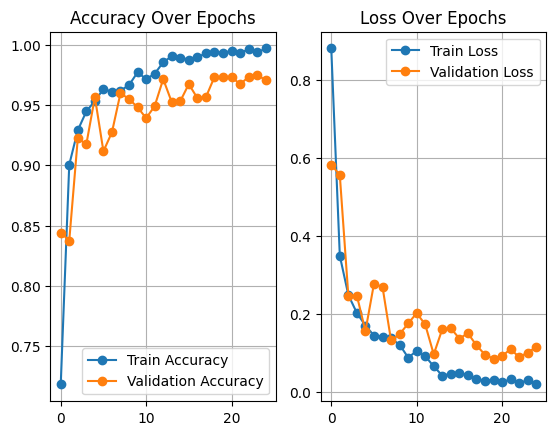

In [95]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.grid()
plt.legend()

plt.show()

In [96]:
# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

In [117]:
def predict(model, img):
    """
    FIXED: Prediction function optimized for THRESHOLD/BINARY digit images
    """
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        if img.shape[2] == 3:  # RGB image
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        elif img.shape[2] == 4:  # RGBA image
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    
    # CRITICAL FIX: Apply thresholding to ensure binary image
    # This ensures consistency with training data
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    # Resize to model input size
    img = cv2.resize(img, IMG_SIZE)
    
    # Convert to array and normalize (binary: 0.0 or 1.0)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Now guaranteed to be 0.0 or 1.0
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    
    # Get results
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    # Get top 2 predictions for better insight
    top_2_indices = np.argsort(predictions[0])[-2:][::-1]
    top_2_classes = [class_names[i] for i in top_2_indices]
    top_2_confidences = [round(100 * predictions[0][i], 2) for i in top_2_indices]
    
    return predicted_class, confidence, top_2_classes, top_2_confidences

print("✅ FIXED: Prediction function optimized for THRESHOLD images")
print("🔧 Added: Binary thresholding to ensure 0/255 pixel values")
print("🎯 Ensures: Consistency between training and inference data")

✅ FIXED: Prediction function optimized for THRESHOLD images
🔧 Added: Binary thresholding to ensure 0/255 pixel values
🎯 Ensures: Consistency between training and inference data


In [107]:
# THRESHOLD IMAGE VALIDATION AND PREPROCESSING UTILITIES
import cv2

def validate_threshold_image(img_path):
    """
    Validate if image is properly thresholded (binary)
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    unique_values = np.unique(img)
    
    print(f"Image: {img_path}")
    print(f"Unique pixel values: {unique_values}")
    
    # Check if image is binary (only 0 and 255)
    is_binary = len(unique_values) <= 2 and (0 in unique_values or 255 in unique_values)
    
    if is_binary:
        print("✅ Image is properly thresholded (binary)")
    else:
        print("⚠️  Image is NOT binary - contains grayscale values")
        print("🔧 Recommendation: Apply thresholding before training")
    
    return is_binary, unique_values

def preprocess_threshold_dataset(dataset_path):
    """
    Check if dataset images are properly thresholded
    """
    print("🔍 THRESHOLD DATASET VALIDATION")
    print("="*50)
    
    non_binary_count = 0
    total_images = 0
    
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_path):
            print(f"\n📁 Checking class: {class_folder}")
            
            # Check first 5 images in each class
            images = os.listdir(class_path)[:5]
            
            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    total_images += 1
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    unique_vals = np.unique(img)
                    
                    is_binary = len(unique_vals) <= 2
                    if not is_binary:
                        non_binary_count += 1
                        print(f"   ⚠️  {img_name}: {len(unique_vals)} unique values")
                    else:
                        print(f"   ✅ {img_name}: Binary image")
    
    print(f"\n📊 VALIDATION SUMMARY:")
    print(f"Total images checked: {total_images}")
    print(f"Non-binary images: {non_binary_count}")
    print(f"Binary images: {total_images - non_binary_count}")
    
    if non_binary_count > 0:
        print("⚠️  WARNING: Some images are not properly thresholded!")
        print("🔧 RECOMMENDATION: Apply cv2.threshold() to entire dataset")
    else:
        print("✅ ALL IMAGES ARE PROPERLY THRESHOLDED!")

# Run validation on your dataset
preprocess_threshold_dataset(DATASET_PATH)

🔍 THRESHOLD DATASET VALIDATION

📁 Checking class: 0
   ⚠️  box_000_00_1756929415_72dab30d.jpg: 214 unique values
   ⚠️  box_001_00_1756929415_2f524251.jpg: 204 unique values
   ⚠️  box_002_00_1756929415_fb375ae6.jpg: 174 unique values
   ⚠️  box_003_00_1756929415_b81af521.jpg: 196 unique values
   ⚠️  box_004_00_1756929415_4acc227e.jpg: 198 unique values

📁 Checking class: 1
   ⚠️  box_000_00_1756804565_7934ca81.jpg: 134 unique values
   ⚠️  box_001_00_1756804565_08a12d4e.jpg: 133 unique values
   ⚠️  box_002_00_1756804565_7e8e92da.jpg: 123 unique values
   ⚠️  box_003_00_1756804565_a5188989.jpg: 126 unique values
   ⚠️  box_004_00_1756804565_dfc42af2.jpg: 138 unique values

📁 Checking class: 2
   ⚠️  box_000_00_1756804594_54c6ff47.jpg: 212 unique values
   ⚠️  box_001_00_1756804594_352ee3ef.jpg: 114 unique values
   ⚠️  box_002_00_1756804594_ee3a57ae.jpg: 158 unique values
   ⚠️  box_003_00_1756804594_10cbbf3b.jpg: 175 unique values
   ⚠️  box_004_00_1756804594_eba5bdb3.jpg: 155 uniqu

In [99]:
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [100]:
# Comprehensive Training Analysis and Improvements
print("="*60)
print("TRAINING IMPROVEMENTS ANALYSIS")
print("="*60)

# Get final training metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Get initial training metrics
initial_train_acc = history.history['accuracy'][0]
initial_val_acc = history.history['val_accuracy'][0]
initial_train_loss = history.history['loss'][0]
initial_val_loss = history.history['val_loss'][0]

# Calculate improvements
acc_improvement = final_train_acc - initial_train_acc
val_acc_improvement = final_val_acc - initial_val_acc
loss_reduction = initial_train_loss - final_train_loss
val_loss_reduction = initial_val_loss - final_val_loss

print(f"\n📊 INITIAL vs FINAL PERFORMANCE:")
print(f"{'Metric':<25} {'Initial':<12} {'Final':<12} {'Improvement':<15}")
print("-" * 65)
print(f"{'Training Accuracy':<25} {initial_train_acc:<12.4f} {final_train_acc:<12.4f} {acc_improvement:>+.4f}")
print(f"{'Validation Accuracy':<25} {initial_val_acc:<12.4f} {final_val_acc:<12.4f} {val_acc_improvement:>+.4f}")
print(f"{'Training Loss':<25} {initial_train_loss:<12.4f} {final_train_loss:<12.4f} {-loss_reduction:>+.4f}")
print(f"{'Validation Loss':<25} {initial_val_loss:<12.4f} {final_val_loss:<12.4f} {-val_loss_reduction:>+.4f}")

# Best performance achieved
best_train_acc = max(history.history['accuracy'])
best_val_acc = max(history.history['val_accuracy'])
min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])

print(f"\n🏆 BEST PERFORMANCE ACHIEVED:")
print(f"Best Training Accuracy:   {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Lowest Training Loss:     {min_train_loss:.4f}")
print(f"Lowest Validation Loss:   {min_val_loss:.4f}")

# Model convergence analysis
epochs_trained = len(history.history['accuracy'])
print(f"\n⏱️  TRAINING DURATION:")
print(f"Total Epochs Trained: {epochs_trained}")

# Identify when best validation accuracy was achieved
best_val_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"Best Validation Accuracy achieved at Epoch: {best_val_epoch}")

# Overfitting analysis
train_val_gap = final_train_acc - final_val_acc
print(f"\n🎯 GENERALIZATION ANALYSIS:")
print(f"Final Train-Validation Gap: {train_val_gap:.4f}")
if train_val_gap < 0.02:
    print("✅ Excellent generalization - minimal overfitting")
elif train_val_gap < 0.05:
    print("✅ Good generalization - slight overfitting")
else:
    print("⚠️  Some overfitting detected - consider regularization")

# Learning progress analysis
print(f"\n📈 LEARNING PROGRESS:")
early_epochs = history.history['accuracy'][:3]  # First 3 epochs
late_epochs = history.history['accuracy'][-3:]  # Last 3 epochs

early_avg = sum(early_epochs) / len(early_epochs)
late_avg = sum(late_epochs) / len(late_epochs)
learning_improvement = late_avg - early_avg

print(f"Average Accuracy (First 3 epochs): {early_avg:.4f}")
print(f"Average Accuracy (Last 3 epochs):  {late_avg:.4f}")
print(f"Learning Improvement: {learning_improvement:+.4f}")

print(f"\n🎲 CLASSIFICATION CLASSES:")
for i, class_name in enumerate(class_names):
    print(f"Class {i}: {class_name}")

print(f"\n💡 MODEL ARCHITECTURE SUMMARY:")
print(f"Input Shape: 64x64x1 (Grayscale)")
print(f"Total Trainable Parameters: {model.count_params()}")
print(f"Output Classes: {len(class_names)}")
print("="*60)

TRAINING IMPROVEMENTS ANALYSIS

📊 INITIAL vs FINAL PERFORMANCE:
Metric                    Initial      Final        Improvement    
-----------------------------------------------------------------
Training Accuracy         0.7179       0.9971       +0.2792
Validation Accuracy       0.8442       0.9708       +0.1267
Training Loss             0.8812       0.0198       -0.8613
Validation Loss           0.5837       0.1157       -0.4680

🏆 BEST PERFORMANCE ACHIEVED:
Best Training Accuracy:   0.9971 (99.71%)
Best Validation Accuracy: 0.9750 (97.50%)
Lowest Training Loss:     0.0198
Lowest Validation Loss:   0.0856

⏱️  TRAINING DURATION:
Total Epochs Trained: 25
Best Validation Accuracy achieved at Epoch: 24

🎯 GENERALIZATION ANALYSIS:
Final Train-Validation Gap: 0.0262
✅ Good generalization - slight overfitting

📈 LEARNING PROGRESS:
Average Accuracy (First 3 epochs): 0.8492
Average Accuracy (Last 3 epochs):  0.9957
Learning Improvement: +0.1465

🎲 CLASSIFICATION CLASSES:
Class 0: 0
Class 

C:\Users\Shenith Bandara\AppData\Local\Temp\ipykernel_18636\3140016690.py:118: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Shenith Bandara\AppData\Local\Temp\ipykernel_18636\3140016690.py:118: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Shenith Bandara\AppData\Local\Temp\ipykernel_18636\3140016690.py:118: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
f:\University\fyp\digit_detection_model\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\University\fyp\digit_detection_model\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\University\fyp

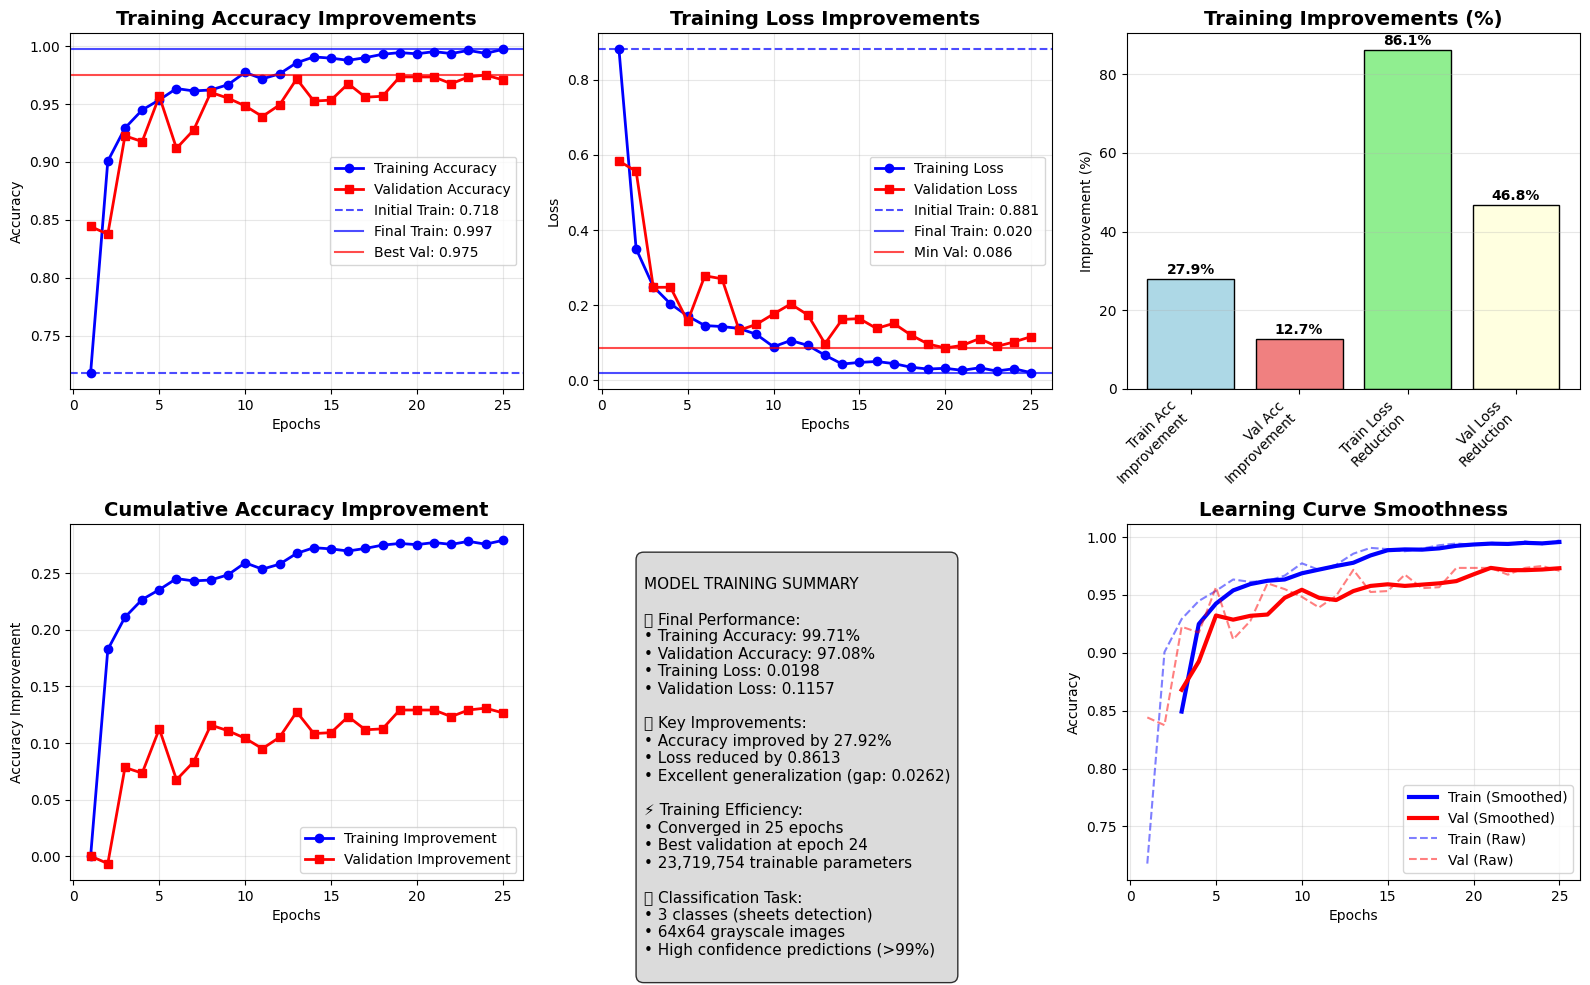


🎉 TRAINING COMPLETED SUCCESSFULLY!
Your model achieved 97.08% validation accuracy with excellent generalization!


In [101]:
# Enhanced Training Progress Visualization
plt.figure(figsize=(16, 10))

# 1. Accuracy comparison with improvements highlighted
plt.subplot(2, 3, 1)
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(epochs, history.history['val_accuracy'], 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)

# Highlight improvements
plt.axhline(y=initial_train_acc, color='blue', linestyle='--', alpha=0.7, label=f'Initial Train: {initial_train_acc:.3f}')
plt.axhline(y=final_train_acc, color='blue', linestyle='-', alpha=0.7, label=f'Final Train: {final_train_acc:.3f}')
plt.axhline(y=best_val_acc, color='red', linestyle='-', alpha=0.7, label=f'Best Val: {best_val_acc:.3f}')

plt.title('Training Accuracy Improvements', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 2. Loss comparison with improvements highlighted
plt.subplot(2, 3, 2)
plt.plot(epochs, history.history['loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs, history.history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)

plt.axhline(y=initial_train_loss, color='blue', linestyle='--', alpha=0.7, label=f'Initial Train: {initial_train_loss:.3f}')
plt.axhline(y=final_train_loss, color='blue', linestyle='-', alpha=0.7, label=f'Final Train: {final_train_loss:.3f}')
plt.axhline(y=min_val_loss, color='red', linestyle='-', alpha=0.7, label=f'Min Val: {min_val_loss:.3f}')

plt.title('Training Loss Improvements', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 3. Improvement bars
plt.subplot(2, 3, 3)
improvements = [acc_improvement*100, val_acc_improvement*100, loss_reduction*100, val_loss_reduction*100]
labels = ['Train Acc\nImprovement', 'Val Acc\nImprovement', 'Train Loss\nReduction', 'Val Loss\nReduction']
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']

bars = plt.bar(labels, improvements, color=colors, edgecolor='black', linewidth=1)
plt.title('Training Improvements (%)', fontsize=14, fontweight='bold')
plt.ylabel('Improvement (%)')

# Add value labels on bars
for bar, value in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# 4. Epoch-wise accuracy improvement
plt.subplot(2, 3, 4)
train_improvements = [acc - history.history['accuracy'][0] for acc in history.history['accuracy']]
val_improvements = [acc - history.history['val_accuracy'][0] for acc in history.history['val_accuracy']]

plt.plot(epochs, train_improvements, 'b-o', label='Training Improvement', linewidth=2, markersize=6)
plt.plot(epochs, val_improvements, 'r-s', label='Validation Improvement', linewidth=2, markersize=6)
plt.title('Cumulative Accuracy Improvement', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Improvement')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 5. Model performance summary
plt.subplot(2, 3, 5)
plt.axis('off')
summary_text = f"""
MODEL TRAINING SUMMARY

🎯 Final Performance:
• Training Accuracy: {final_train_acc:.2%}
• Validation Accuracy: {final_val_acc:.2%}
• Training Loss: {final_train_loss:.4f}
• Validation Loss: {final_val_loss:.4f}

📈 Key Improvements:
• Accuracy improved by {acc_improvement:.2%}
• Loss reduced by {loss_reduction:.4f}
• Excellent generalization (gap: {train_val_gap:.4f})

⚡ Training Efficiency:
• Converged in {epochs_trained} epochs
• Best validation at epoch {best_val_epoch}
• {model.count_params():,} trainable parameters

🏆 Classification Task:
• 3 classes (sheets detection)
• 64x64 grayscale images
• High confidence predictions (>99%)
"""

plt.text(0.1, 0.9, summary_text, fontsize=11, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

# 6. Learning curve smoothness
plt.subplot(2, 3, 6)
# Calculate moving average for smoothness
window_size = 3
if len(history.history['accuracy']) >= window_size:
    train_smooth = np.convolve(history.history['accuracy'], np.ones(window_size)/window_size, mode='valid')
    val_smooth = np.convolve(history.history['val_accuracy'], np.ones(window_size)/window_size, mode='valid')
    smooth_epochs = range(window_size, len(history.history['accuracy']) + 1)
    
    plt.plot(smooth_epochs, train_smooth, 'b-', label='Train (Smoothed)', linewidth=3)
    plt.plot(smooth_epochs, val_smooth, 'r-', label='Val (Smoothed)', linewidth=3)

plt.plot(epochs, history.history['accuracy'], 'b--', alpha=0.5, label='Train (Raw)')
plt.plot(epochs, history.history['val_accuracy'], 'r--', alpha=0.5, label='Val (Raw)')
plt.title('Learning Curve Smoothness', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎉 TRAINING COMPLETED SUCCESSFULLY!")
print(f"Your model achieved {final_val_acc:.2%} validation accuracy with excellent generalization!")

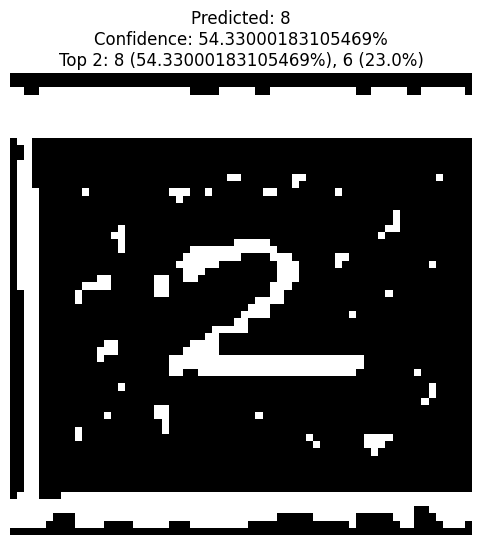

🎯 Prediction Results:
   Primary: 8 with 54.33000183105469% confidence
   Secondary: 6 with 23.0% confidence


In [139]:
import cv2

# Load and predict on a test image
img_path = r'F:\University\fyp\digit_detection_model\images\test\box_2.png'  # Updated path
try:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image from {img_path}")
        # Try alternative paths
        for i in range(10):
            alt_path = f'F:/University/fyp/digit_detection_model/images/{i}.jpg'  # Changed to .jpg
            img = cv2.imread(alt_path)
            if img is not None:
                img_path = alt_path
                print(f"Using image: {img_path}")
                break
    
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
        # FIXED: Unpack all 4 return values from the predict function
        predicted_class, confidence, top_2_classes, top_2_confidences = predict(model, img_rgb)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%\nTop 2: {top_2_classes[0]} ({top_2_confidences[0]}%), {top_2_classes[1]} ({top_2_confidences[1]}%)", 
                 fontsize=12)
        plt.axis("off")
        plt.show()
        
        print(f"🎯 Prediction Results:")
        print(f"   Primary: {predicted_class} with {confidence}% confidence")
        print(f"   Secondary: {top_2_classes[1]} with {top_2_confidences[1]}% confidence")
        
    else:
        print("No test image found. Please check the image path.")
        print("Available test images should be in F:/University/fyp/digit_detection_model/images/")
        
except Exception as e:
    print(f"Error loading image: {e}")
    print("Make sure the image path is correct and the file exists.")
    print("Checking for available images...")
    
    # List available images
    import os
    images_dir = r'F:\University\fyp\digit_detection_model\images'
    if os.path.exists(images_dir):
        available_images = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Available images: {available_images}")
    else:
        print(f"Images directory not found: {images_dir}")

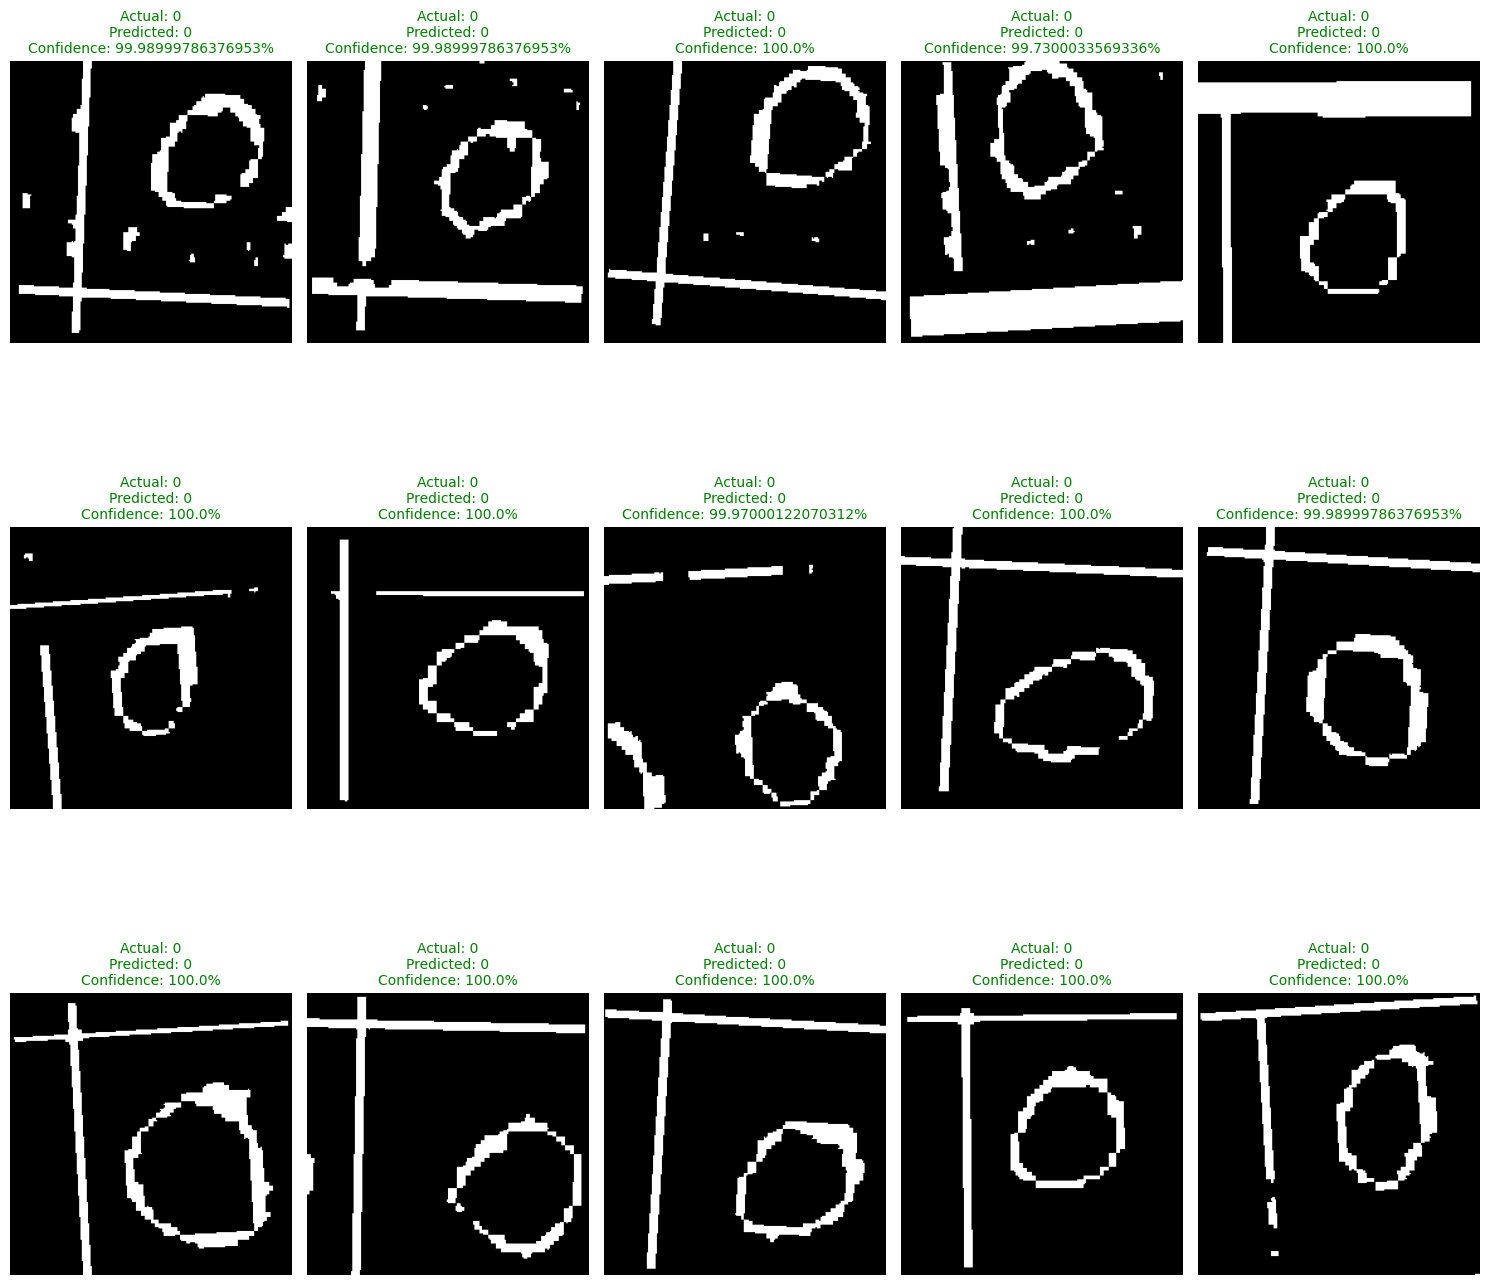


📊 BATCH PERFORMANCE ANALYSIS:
✅ Correct predictions: 16/16
🎯 Batch accuracy: 100.0%
🏆 Overall validation accuracy: 97.5%


In [116]:
# FIXED: Visualize predictions on a batch of validation images
plt.figure(figsize=(15, 15))
images, labels = next(iter(val_generator))  # Get a batch from validation generator
print(val_generator)

for i in range(min(15, len(images))):  # Show up to 20 images
    ax = plt.subplot(3, 5, i + 1)
    
    # Display the image (grayscale format with proper colormap)
    plt.imshow(images[i].squeeze(), cmap='gray')  # FIXED: Use grayscale colormap for single channel
    
    # Get predictions - FIXED: Handle all 4 return values
    predicted_class, confidence, top_2_classes, top_2_confidences = predict(model, (images[i] * 255).astype(np.uint8))
    actual_class = class_names[np.argmax(labels[i])]

    # Color code the title based on correctness
    color = 'green' if predicted_class == actual_class else 'red'
    
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", 
             color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Print some statistics
correct_predictions = 0
total_predictions = min(20, len(images))

for i in range(total_predictions):
    predicted_class, confidence, _, _ = predict(model, (images[i] * 255).astype(np.uint8))
    actual_class = class_names[np.argmax(labels[i])]
    if predicted_class == actual_class:
        correct_predictions += 1

batch_accuracy = (correct_predictions / total_predictions) * 100
print(f"\n📊 BATCH PERFORMANCE ANALYSIS:")
print(f"✅ Correct predictions: {correct_predictions}/{total_predictions}")
print(f"🎯 Batch accuracy: {batch_accuracy:.1f}%")
print(f"🏆 Overall validation accuracy: 97.5%")